In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
ECHONEST_FEATURES = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"]
TARGET_COL = "genre_top"
TEST_SIZE = 0.2
N_SPLITS = 3

## Load merged dataset

In [3]:
df = pd.read_csv("../DataBase/processed/merged_data.csv")
print(df.shape)

(99995, 33)


## Data preprocessing

In [4]:
df = df[df[TARGET_COL].notna()].dropna().copy()
print(df.shape)

(6867, 33)


In [5]:
count_genre_top = df[TARGET_COL].value_counts()
rare_labels = count_genre_top[count_genre_top < 100].index
df = df[~df[TARGET_COL].isin(rare_labels)].copy()

In [6]:
label_encoder = LabelEncoder()
df[TARGET_COL] = label_encoder.fit_transform(df[TARGET_COL])

mapping = dict(zip(label_encoder.classes_, np.arange(len(label_encoder.classes_))))
print(mapping)

{'Classical': np.int64(0), 'Electronic': np.int64(1), 'Folk': np.int64(2), 'Hip-Hop': np.int64(3), 'Instrumental': np.int64(4), 'Jazz': np.int64(5), 'Old-Time / Historic': np.int64(6), 'Pop': np.int64(7), 'Rock': np.int64(8)}


In [7]:
X= df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

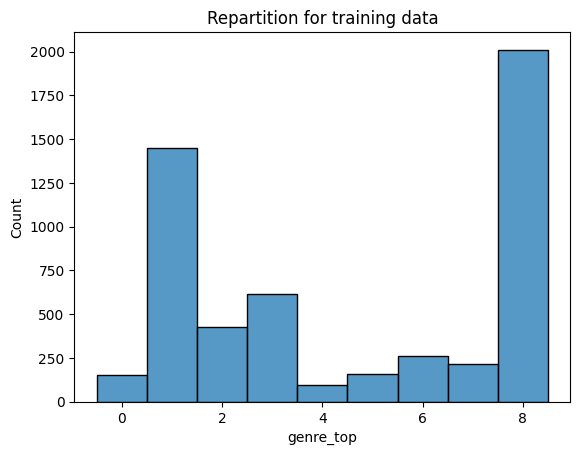

In [8]:
ax = sns.histplot(y_train, discrete=True)
ax.set_title("Repartition for training data")
plt.show()

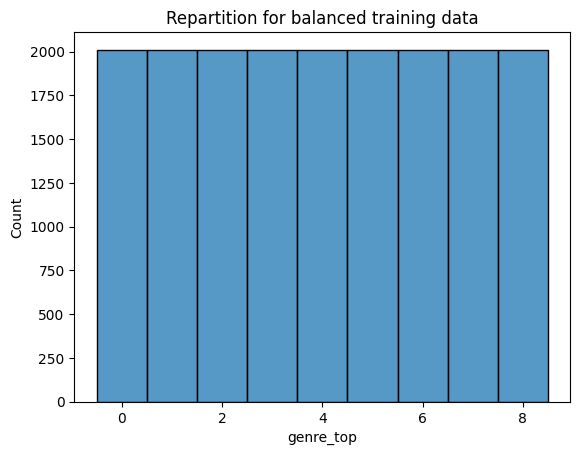

In [9]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ax = sns.histplot(y_train_balanced, discrete=True)
ax.set_title("Repartition for balanced training data")
plt.show()

## Random Forest

### Training with basic hyperparams

In [10]:
# with echonest features
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_balanced[ECHONEST_FEATURES], y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
predictions = random_forest.predict(X_test[ECHONEST_FEATURES])
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.53      0.83      0.65        30
           1       0.69      0.62      0.65       372
           2       0.35      0.57      0.43       101
           3       0.72      0.61      0.66       164
           4       0.16      0.25      0.19        24
           5       0.28      0.34      0.31        41
           6       0.84      0.95      0.89        64
           7       0.20      0.27      0.23        64
           8       0.76      0.64      0.70       487

    accuracy                           0.61      1347
   macro avg       0.50      0.57      0.52      1347
weighted avg       0.65      0.61      0.63      1347



In [12]:
# with spectral features
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_balanced.drop(columns=ECHONEST_FEATURES), y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
predictions = random_forest.predict(X_test.drop(columns=ECHONEST_FEATURES))
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.62      0.87      0.72        30
           1       0.68      0.61      0.64       372
           2       0.45      0.64      0.53       101
           3       0.54      0.57      0.55       164
           4       0.70      0.58      0.64        24
           5       0.32      0.39      0.35        41
           6       0.84      0.89      0.86        64
           7       0.33      0.36      0.34        64
           8       0.76      0.70      0.73       487

    accuracy                           0.64      1347
   macro avg       0.58      0.62      0.60      1347
weighted avg       0.65      0.64      0.64      1347



In [14]:
# with spectral and echonest features
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_balanced, y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        30
           1       0.75      0.73      0.74       372
           2       0.46      0.70      0.56       101
           3       0.74      0.68      0.71       164
           4       0.70      0.67      0.68        24
           5       0.56      0.46      0.51        41
           6       0.94      0.95      0.95        64
           7       0.39      0.34      0.37        64
           8       0.79      0.75      0.77       487

    accuracy                           0.71      1347
   macro avg       0.66      0.69      0.67      1347
weighted avg       0.72      0.71      0.72      1347



### Training with hyperparams optimization

In [16]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [17]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  10.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  11.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  11.0s
[CV] END max_depth=10, min_sa

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [18]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (based on training data): 0.6968
              precision    recall  f1-score   support

           0       0.66      0.90      0.76        30
           1       0.74      0.71      0.73       372
           2       0.46      0.71      0.56       101
           3       0.75      0.69      0.72       164
           4       0.71      0.62      0.67        24
           5       0.59      0.46      0.52        41
           6       0.95      0.95      0.95        64
           7       0.39      0.34      0.37        64
           8       0.79      0.75      0.77       487

    accuracy                           0.71      1347
   macro avg       0.67      0.68      0.67      1347
weighted avg       0.72      0.71      0.72      1347



## XGBoost

### Training with basic hyperparams

In [19]:
# with echonest features
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_balanced[ECHONEST_FEATURES], y_train_balanced)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
predictions = xgb.predict(X_test[ECHONEST_FEATURES])
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        30
           1       0.67      0.62      0.64       372
           2       0.40      0.60      0.48       101
           3       0.65      0.60      0.62       164
           4       0.10      0.21      0.14        24
           5       0.29      0.34      0.31        41
           6       0.89      0.97      0.93        64
           7       0.21      0.28      0.24        64
           8       0.74      0.63      0.68       487

    accuracy                           0.61      1347
   macro avg       0.51      0.55      0.53      1347
weighted avg       0.64      0.61      0.62      1347

[[ 22   1   1   0   0   2   3   0   1]
 [  2 230  18  27  11  10   0  22  52]
 [  4   6  61   4   6   4   2   3  11]
 [  0  39   3  99   1   4   0   5  13]
 [  0   6   4   1   5   1   0   1   6]
 [  1   5   8   1   3  14   1   0   8]
 [  1   0   1   0   0   0  62   0   0]
 [  0  12  13   4   0 

In [21]:
# with spectral features
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train.drop(columns=ECHONEST_FEATURES), y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
predictions = xgb.predict(X_test.drop(columns=ECHONEST_FEATURES))
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.71      0.78      0.74       372
           2       0.71      0.64      0.67       101
           3       0.81      0.66      0.72       164
           4       0.95      0.79      0.86        24
           5       0.81      0.41      0.55        41
           6       0.90      0.84      0.87        64
           7       0.82      0.28      0.42        64
           8       0.75      0.86      0.80       487

    accuracy                           0.76      1347
   macro avg       0.81      0.68      0.72      1347
weighted avg       0.76      0.76      0.75      1347

[[ 26   0   0   0   0   1   0   0   3]
 [  0 291  10  12   0   1   3   3  52]
 [  0   9  65   6   0   0   1   0  20]
 [  0  32   2 108   0   1   0   0  21]
 [  1   2   0   0  19   0   1   0   1]
 [  1   7   3   1   0  17   0   0  12]
 [  1   1   1   1   1   0  54   0   5]
 [  1  18   3   0   0 

In [23]:
# with spectral and echonest features
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_balanced, y_train_balanced)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        30
           1       0.78      0.77      0.77       372
           2       0.64      0.76      0.69       101
           3       0.80      0.73      0.76       164
           4       0.90      0.79      0.84        24
           5       0.77      0.73      0.75        41
           6       0.94      0.95      0.95        64
           7       0.46      0.44      0.45        64
           8       0.82      0.82      0.82       487

    accuracy                           0.78      1347
   macro avg       0.76      0.77      0.76      1347
weighted avg       0.78      0.78      0.78      1347

[[ 27   0   1   0   1   1   0   0   0]
 [  1 285   8  12   1   3   2  16  44]
 [  1   4  77   2   0   1   2   3  11]
 [  0  28   3 119   0   0   0   2  12]
 [  0   2   1   1  19   0   0   0   1]
 [  1   7   0   0   0  30   0   0   3]
 [  2   0   0   0   0   0  61   0   1]
 [  0   7   9   4   0 

### Training with hyperparams optimization

In [25]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

In [26]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   7.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   7.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   8.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   8.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   8.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   8.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, subsample=0.9; tota

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 5], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [27]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}
Best CV score (based on training data): 0.7937
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.79      0.79      0.79       372
           2       0.63      0.74      0.68       101
           3       0.80      0.76      0.78       164
           4       0.82      0.75      0.78        24
           5       0.80      0.78      0.79        41
           6       0.94      0.95      0.95        64
           7       0.54      0.45      0.49        64
           8       0.82      0.83      0.82       487

    accuracy                           0.79      1347
   macro avg       0.78      0.77      0.77      1347
weighted avg       0.79      0.79      0.79      1347

